In [2]:
import numpy as np

In [5]:

import torch
import torch.nn as nn
import torchvision.models as models
#import utils
import torch.nn.functional as F

In [6]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    
    AutoTokenizer, AutoFeatureExtractor,
    
    AutoModel,            
    
    TrainingArguments, Trainer,
    
    logging
)
import nltk
import re
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
from nltk.corpus import wordnet

In [8]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
from sklearn.metrics import accuracy_score, f1_score

In [3]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
os.environ['HF_HOME'] = os.path.join(".", "cache")

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_caching_enabled(True)
logging.set_verbosity_error()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

<ipython-input-10-27790b2614da>:5: FutureWarning: set_caching_enabled is deprecated and will be removed in the next major version of datasets. Use datasets.enable_caching() or datasets.disable_caching() instead. This function will be removed in a future version of datasets.
  set_caching_enabled(True)


In [45]:
dataset = load_dataset(
    "csv", 
    data_files={
        "train": os.path.join( "drive","MyDrive","dataset", "data_train.csv"),
        "test": os.path.join( "drive","MyDrive","dataset", "data_eval.csv")
    }
)

with open(os.path.join( "drive","MyDrive","dataset", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()
#dataset['train']=dataset['train'][:5000]
#dataset['test']=dataset['test'][:3000]
#dataset=dataset[0:50]
#print(dataset)
dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 6795
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 5673
    })
})

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    image = Image.open(os.path.join( "drive","MyDrive","dataset", "images", data[id]["image_id"] + ".png"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

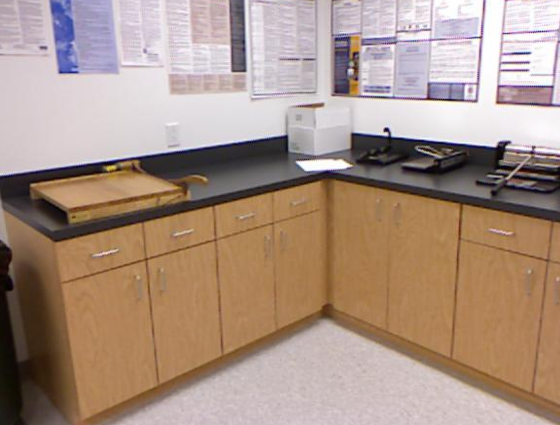

Question:	 what is on the right most side on the table
Answer:		 machine (Label: 320)


In [13]:
showExample()

In [14]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join("drive","MyDrive","dataset", "images", image_id + ".png")).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }
            
    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

In [15]:
class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'bert-base-uncased',
            pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'):
     
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        
        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):
        
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)
        
        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out

In [16]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )


    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

In [18]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a) 
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score 

In [19]:
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

In [20]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        #"wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

In [17]:
args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345, 
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,             # Save only the last 3 checkpoints at any given time while training 
    #metric_for_best_model='wups',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    remove_unused_columns=False,
    num_train_epochs=30,
    #fp16=True,
    # warmup_ratio=0.01,
    # learning_rate=5e-4,
    # weight_decay=1e-4,
    # gradient_accumulation_steps=2,
    #dataloader_num_workers=4,
    load_best_model_at_end=True,
)


In [21]:
def createAndTrainModel(dataset, args, text_model='bert-base-uncased', image_model='google/vit-base-patch16-224-in21k', multimodal_model='bert_vit'):
    collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)
    
    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("..", "checkpoint", multimodal_model)
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )
    
    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()
    
    return collator, model, train_multi_metrics, eval_multi_metrics

In [ ]:
train=dataset['train'][:64]
test=dataset['test'][0:20]
#dataset['train'][0:2]
train

In [23]:
collator, model = createMultimodalVQACollatorAndModel('bert-base-uncased', 'google/vit-base-patch16-224-in21k')

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [24]:
model

MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
x=model.parameters()
for item in x:
  print(item.numel())

In [22]:
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


KeyError: ignored

In [25]:
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 5.8838, 'learning_rate': 4.7647058823529414e-05, 'epoch': 0.24}
{'eval_loss': 5.2081379890441895, 'eval_wups': 0.10723593658379665, 'eval_acc': 0.0495328750220342, 'eval_f1': 0.0008722285396654956, 'eval_runtime': 185.7992, 'eval_samples_per_second': 30.533, 'eval_steps_per_second': 1.911, 'epoch': 0.24}
{'loss': 5.1386, 'learning_rate': 4.5294117647058826e-05, 'epoch': 0.47}
{'eval_loss': 4.79814338684082, 'eval_wups': 0.1028420863193572, 'eval_acc': 0.048122686409307246, 'eval_f1': 0.0008628270630257226, 'eval_runtime': 216.4892, 'eval_samples_per_second': 26.205, 'eval_steps_per_second': 1.64, 'epoch': 0.47}
{'loss': 4.8864, 'learning_rate': 4.294117647058823e-05, 'epoch': 0.71}
{'eval_loss': 4.664660930633545, 'eval_wups': 0.15172056283391358, 'eval_acc': 0.09730301427815971, 'eval_f1': 0.002427878254691661, 'eval_runtime': 193.8724, 'eval_samples_per_second': 29.262, 'eval_steps_per_second': 1.831, 'epoch': 0.71}
{'loss': 4.7961, 'learning_rate': 4.058823529411765e-05, 'e

In [ ]:
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 5.9076, 'learning_rate': 4.960784313725491e-05, 'epoch': 0.24}
{'eval_loss': 5.264575481414795, 'eval_acc': 0.046536224219989424, 'eval_f1': 0.0006601063440304489, 'eval_runtime': 386.4205, 'eval_samples_per_second': 14.681, 'eval_steps_per_second': 0.919, 'epoch': 0.24}
{'loss': 5.2013, 'learning_rate': 4.9215686274509804e-05, 'epoch': 0.47}
{'eval_loss': 4.7950310707092285, 'eval_acc': 0.11246254186497444, 'eval_f1': 0.002987042130348641, 'eval_runtime': 165.8962, 'eval_samples_per_second': 34.196, 'eval_steps_per_second': 2.14, 'epoch': 0.47}
{'loss': 4.8201, 'learning_rate': 4.882352941176471e-05, 'epoch': 0.71}
{'eval_loss': 4.52902364730835, 'eval_acc': 0.11246254186497444, 'eval_f1': 0.0027777302127116846, 'eval_runtime': 165.2521, 'eval_samples_per_second': 34.329, 'eval_steps_per_second': 2.148, 'epoch': 0.71}
{'loss': 4.6704, 'learning_rate': 4.843137254901961e-05, 'epoch': 0.94}
{'eval_loss': 4.447103977203369, 'eval_acc': 0.12427287149656266, 'eval_f1': 0.003637416

In [26]:
eval_multi_metrics

{'eval_loss': 3.8787102699279785,
 'eval_wups': 0.25689645312194,
 'eval_acc': 0.19442975497972853,
 'eval_f1': 0.011710596422946874,
 'eval_runtime': 182.2091,
 'eval_samples_per_second': 31.135,
 'eval_steps_per_second': 1.948,
 'epoch': 5.0}

In [28]:
model


MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [27]:
model = MultimodalVQAModel()

# We use the checkpoint giving best results
model.load_state_dict(torch.load(os.path.join("..", "checkpoint", "bert_vit", "checkpoint-1500", "pytorch_model.bin")))
model.to(device) 

FileNotFoundError: ignored

In [ ]:

image_pattern = re.compile("( (in |on |of )?(the |this )?(image\d*) \?)")

with open(os.path.join("dataset", "all_qa_pairs.txt")) as f:
    qa_data = [x.replace("\n", "") for x in f.readlines()]

df = pd.DataFrame({"question": [], "answer": [], "image_id":[]})

for i in range(0, len(qa_data), 2):
    img_id = image_pattern.findall(qa_data[i])[0][3]
    question = qa_data[i].replace(image_pattern.findall(qa_data[i])[0][0], "")
    record = {
        "question": question,
        "answer": qa_data[i+1],
        "image_id": img_id,
    }
    df = df.append(record, ignore_index=True)


answer_space = []
for ans in df.answer.to_list():
    answer_space = answer_space + [ans] if "," not in ans else answer_space + ans.replace(" ", "").split(",") 

answer_space = list(set(answer_space))
answer_space.sort()
with open(os.path.join("dataset", "answer_space.txt"), "w") as f:
    f.writelines("\n".join(answer_space))


train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.to_csv(os.path.join("dataset", "data_train.csv"), index=None)
test_df.to_csv(os.path.join("dataset", "data_eval.csv"), index=None)

In [ ]:
dataset = load_dataset(
    "csv", 
    data_files={
        "train": os.path.join( "dataset", "data_train.csv"),
        "test": os.path.join( "dataset", "data_eval.csv")
    }
)

with open(os.path.join("..", "dataset", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

In [ ]:

class MultimodalVQAModel(nn.Module):
    
    def __init__(self,  pretrained_text_name, pretrained_image_name, num_labels=512, intermediate_dim=512, dropout=0.5):
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        

        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)

        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        

        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):
        
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)
        
        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out

In [ ]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):

    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)
    multimodal_collator = MultimodalCollator(tokenizer=tokenizer, preprocessor=preprocessor)
  
    multimodal_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    
    return multimodal_collator, multimodal_model

In [23]:
#@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join("dataset", "images", image_id + ".png")).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }
            
    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

In [ ]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )


    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

In [ ]:
multi_args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345, 
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,              
    metric_for_best_model='wups',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=5,
    fp16=True,
    dataloader_num_workers=8,
    load_best_model_at_end=True,
)



In [ ]:
collator, model = createMultimodalVQACollatorAndModel("bert-base-uncased", "google/vit-base-patch16-224-in21k")

multi_trainer = Trainer(
    model,
    multi_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=collator,
    compute_metrics=compute_metrics
)

train_multi_metrics = multi_trainer.train()

eval_multi_metrics = multi_trainer.evaluate()

In [ ]:
def loadAnswerSpace() -> List[str]:
    with open(os.path.join("dataset", "answer_space.txt")) as f:
        answer_space = f.read().splitlines()
    return answer_space


  def tokenizeQuestion(text_encoder, question, device) -> Dict:
    tokenizer = transformers.AutoTokenizer.from_pretrained(text_encoder)
    encoded_text = tokenizer(
        text=[question],
        padding='longest',
        max_length=24,
        truncation=True,
        return_tensors='pt',
        return_token_type_ids=True,
        return_attention_mask=True,
    )
    return {
        "input_ids": encoded_text['input_ids'].to(device),
        "token_type_ids": encoded_text['token_type_ids'].to(device),
        "attention_mask": encoded_text['attention_mask'].to(device),
    }


  def featurizeImage(image_encoder, img_path, device) -> Dict:
    featurizer = transformers.AutoFeatureExtractor.from_pretrained(image_encoder)
    processed_images = featurizer(
            images=[Image.open(img_path).convert('RGB')],
            return_tensors="pt",
        )
    return {
        "pixel_values": processed_images['pixel_values'].to(device),
    }

  


In [ ]:
question = "What is present on the hanger?"
img_path = "dataset/images/image100.png"
  
answer_space = loadAnswerSpace()

question = question.lower().replace("?", "").strip()                    
tokenized_question = tokenizeQuestion("bert-base-uncased", question, device)
featurized_img = featurizeImage("google/vit-base-patch16-224-in21k", img_path, device)

model = MultimodalVQAModel(
    pretrained_text_name="bert-base-uncased",
    pretrained_image_name="google/vit-base-patch16-224-in21k",
    num_labels=len(answer_space),
    intermediate_dims=512
)
checkpoint = os.path.join("checkpoint", "checkpoint-1500", "pytorch_model.bin")
model.load_state_dict(torch.load(checkpoint))
model.to(device)

model.eval()


input_ids = tokenized_question["input_ids"].to(device)
token_type_ids = tokenized_question["token_type_ids"].to(device)
attention_mask = tokenized_question["attention_mask"].to(device)
pixel_values = featurized_img["pixel_values"].to(device)
output = model(input_ids, pixel_values, attention_mask, token_type_ids)

preds = output["logits"].argmax(axis=-1).cpu().numpy()
answer = answer_space[preds[0]]

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import os
import argparse
import yaml
from typing import Text
import logging

def processDaquarDataset(config_path: Text) -> None:
    with open(config_path) as conf_file:
        config = yaml.safe_load(conf_file)
    
    logging.basicConfig(level=logging.INFO)
    
    image_pattern = re.compile("( (in |on |of )?(the |this )?(image\d*) \?)")

    with open(os.path.join(config["data"]["dataset_folder"], config["data"]["all_qa_pairs_file"])) as f:
        qa_data = [x.replace("\n", "") for x in f.readlines()]
    logging.info("Loaded all question-answer pairs")
    

    df = pd.DataFrame({config["data"]["question_col"]: [], config["data"]["answer_col"]: [], config["data"]["image_col"]:[]})
    
    logging.info("Processing raw QnA pairs...")
    for i in range(0, len(qa_data), 2):
        img_id = image_pattern.findall(qa_data[i])[0][3]
        question = qa_data[i].replace(image_pattern.findall(qa_data[i])[0][0], "")
        record = {
            config["data"]["question_col"]: question,
            config["data"]["answer_col"]: qa_data[i+1],
            config["data"]["image_col"]: img_id,
        }
        df = df.append(record, ignore_index=True)
    
    logging.info("Creating space of all possible answers")
    answer_space = []
    for ans in df.answer.to_list():
        answer_space = answer_space + [ans] if "," not in ans else answer_space + ans.replace(" ", "").split(",") 

    answer_space = list(set(answer_space))
    answer_space.sort()
    with open(os.path.join(config["data"]["dataset_folder"], config["data"]["answer_space"]), "w") as f:
        f.writelines("\n".join(answer_space))


    logging.info("Splitting into train & eval sets")
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    train_df.to_csv(os.path.join(config["data"]["dataset_folder"], config["data"]["train_dataset"]), index=None)
    test_df.to_csv(os.path.join(config["data"]["dataset_folder"], config["data"]["eval_dataset"]), index=None)

    
if __name__ == "__main__":
    args_parser = argparse.ArgumentParser()
    args_parser.add_argument('--config', dest='config', required=True)
    args = args_parser.parse_args()
    
    processDaquarDataset(args.config)

In [ ]:
from typing import Dict, Tuple, List
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from nltk.corpus import wordnet

class WuPalmerScoreCalculator:
    def __init__(self, answer_space: List[str]):
        self.answer_space = answer_space

    def wup_measure(self, a: str, b: str, similarity_threshold: float = 0.925):

        def get_semantic_field(a):
            weight = 1.0
            semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
            return (semantic_field,weight)


        def get_stem_word(a):
            weight = 1.0
            return (a,weight)


        global_weight=1.0

        (a,global_weight_a)=get_stem_word(a)
        (b,global_weight_b)=get_stem_word(b)
        global_weight = min(global_weight_a,global_weight_b)

        if a==b:
            return 1.0*global_weight

        if a==[] or b==[]:
            return 0


        interp_a,weight_a = get_semantic_field(a) 
        interp_b,weight_b = get_semantic_field(b)

        if interp_a == [] or interp_b == []:
            return 0

        global_max=0.0
        for x in interp_a:
            for y in interp_b:
                local_score=x.wup_similarity(y)
                if local_score > global_max:
                    global_max=local_score

        if global_max < similarity_threshold:
            interp_weight = 0.1
        else:
            interp_weight = 1.0

        final_score=global_max*weight_a*weight_b*interp_weight*global_weight
        return final_score


    def batch_wup_measure(self, labels: np.ndarray, preds: np.ndarray) -> float:
        wup_scores = [self.wup_measure(self.answer_space[label], self.answer_space[pred]) for label, pred in zip(labels, preds)]
        return np.mean(wup_scores)


    def compute_metrics(self, eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
        logits, labels = eval_tuple
        preds = logits.argmax(axis=-1)
        return {
            "wups": self.batch_wup_measure(labels, preds),
            "acc": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds, average='macro')
        }

In [ ]:

class MANN(nn.Module):
    def __init__(self,batch,row,col,intermediate_dim):
        super(MANN,self).__init__()
        self.n=row
        self.m=col
        self.batch=batch
        self.memory=torch.rand(row,col)
        self.lstm=nn.LSTM(input_size=intermediate_dim,hidden_size=col,num_layers=1,batch_first=True)
        self.cosine=nn.CosineSimilarity()
        self.gamma=0.95
        self.wtlu=torch.zeros(batch,row)
        self.wtu=torch.zeros(batch,row)
        #self.wtw=torch.zeros(batch,row)
        self.wtr=torch.zeros(batch,row)
        self.h=torch.zeros(batch,col)
        print(self.h)
        self.c=torch.zeros(batch,col)
        self.alpha=nn.Parameter(torch.randn(1))
        self.n=4
        
    def forward(self,vec):
        ot,(ht,ct)=self.lstm(vec,(self.h,self.c))
        #print(ht.size(),ct.size())
        self.h=ht#.squeeze()# B x M
        self.c=ct#.squeeze() #B x M
#         #ot=B x M , 
        #print(self.wtr.size())
        sigma=torch.sigmoid(self.alpha)
        #wtlu=calculate(self.wtu,self.n) 
        wtw=sigma*self.wtr+(1-sigma)*self.wtlu#B x N
        self.wtu=self.gamma*self.wtu+self.wtr+wtw
        self.wtlu=calculate(self.wtu,self.n)
        self.wtr=F.softmax(F.cosine_similarity(ht.unsqueeze(1),self.memory.unsqueeze(0),dim=2)) #B x N
        rt=torch.matmul(self.wtr,self.memory) #B x M
        self.memory=self.memory+torch.matmul(wtw.permute(1,0),ht) # N x B . B x M  = N x M
        #print(self.h.size(),rt.size())
        x=torch.cat((self.h,rt),1)
        #print(x.size())
        return x
        
def calculate(vec,k):
    x=torch.ones(vec.size())
    for i in range(vec.size()[0]):
        _,indices=torch.topk(vec[i],vec.size()[1]-k)
        for ind in indices: 
            x[i][ind]=0
    return x